Based on: https://nn.labml.ai/diffusion/ddpm/index.html

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
batch_size: int = 64
# Download train and test data and transform to pytorch tensor
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform= transforms.ToTensor())
test_data = datasets.MNIST(
    root='input/data',
    train=False,
    download=True,
    transform=transforms.ToTensor())
# Create a DataLoader which provides an iterable for the data
train_load = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)
test_load = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



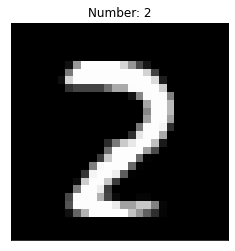

In [ ]:
examples = enumerate(train_load)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt
x = torch.randn([4, 3, 24, 24])
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.title("Number: {}".format(example_targets[0]))
plt.show()

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/Martin/unets.py .


Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import unets
UNet_model = unets.UNet(
        image_size=28,
        in_channels=1,
        out_channels=1,
        num_classes=10
    ).to(device)

In [ ]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for t and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [ ]:
from typing import Tuple, Optional
import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn

class DenoiseDiffusion:
# eps_model = UNet model => ϵθ(xt,t)  |  n_steps = t
  def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model

        # Create β1,…,βT linearly increasing variance schedule (diffusion rate)
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        self.alpha = 1. - self.beta
        # ∏ alpha 
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        # T
        self.n_steps = n_steps

        self.sigma2 = self.beta
#### Get q(x_t|x_0) distribution
  def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # sqrt(gather alpha_bar by t) * x_0
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
       
        var = 1 - gather(self.alpha_bar, t)
        #
        return mean, var
#### Sample from q(x_t|x_0)
  def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):

        # ϵ∼N(0,I)
        if eps is None:
            eps = torch.randn_like(x0)

        # get q(x_t|x_0)
        mean, var = self.q_xt_x0(x0, t)
        # Sample from q(x_t|x_0)
        return mean + (var ** 0.5) * eps

#### Sample from pθ(xt−1∣xt)
  def p_sample(self, xt: torch.Tensor, t: torch.Tensor, labels: torch.Tensor):
        
        # ϵθ(xt,t)
        eps_theta = self.eps_model(xt, t, y=labels)
        # gather alpha_bar by t
        alpha_bar = gather(self.alpha_bar, t)
        # $\alpha_t$
        alpha = gather(self.alpha, t)
          
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5 # αt=1−βt  
        
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        
        # gather σ^2 by t
        var = gather(self.sigma2, t)

        # ϵ∼N(0,I)
        eps = torch.randn(xt.shape, device=xt.device)
        # Sample
        return mean + (var ** .5) * eps
#### Simplified Loss
  def loss(self, x0: torch.Tensor, labels: torch.Tensor, noise: Optional[torch.Tensor] = None):
        # Get batch size
        batch_size = x0.shape[0]
        # Get random t for each sample in the batch
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        # ϵ∼N(0,I)
        if noise is None:
            noise = torch.randn_like(x0)

        # Sample x_t for q(x_t|x_0)
        xt = self.q_sample(x0, t, eps=noise)

        eps_theta = self.eps_model(xt, t, y=labels)

        # MSE loss
        return F.mse_loss(noise, eps_theta)

In [ ]:
!pip install labml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 5.0 MB/s 
     |████████████████████████████████| 181 kB 44.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [ ]:
from typing import List

import torch
import torch.utils.data
import torchvision
from PIL import Image
from torchvision.utils import save_image

class Configs():

    device: torch.device = device

    # U-Net model for ϵθ(xt,t)
    eps_model: unets
    # Diffusion algorithm
    diffusion: DenoiseDiffusion

    # Number of channels in the image
    image_channels: int = 1
    # Image size
    image_size: int = 28

    # Number of time steps T
    n_steps: int = 1000
    # Batch size
    batch_size: int = 64
    # Number of samples to generate
    n_samples: int = 4
    # Learning rate
    learning_rate: float = 2e-5

    # Number of training epochs
    epochs: int = 10

    # Dataset
    dataset: torch.utils.data.Dataset
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        # Create U-Net model for ϵθ(xt,t)
        self.eps_model = UNet_model

        # Create DDPM
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        # Create dataloader
        self.data_loader = train_load
        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

# Sample images
    def sample(self, epoch):

        with torch.no_grad():
            # xT∼p(xT)=N(xT;0,I)
            x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                            device=self.device)
            labels = torch.randint(10, (len(x),), dtype=torch.int64).to(self.device)
            # Remove noise for T steps
            for t_ in range(self.n_steps):
                # t
                t = self.n_steps - t_ - 1
                # Sample from pθ(xt−1∣xt)
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long), labels)

            # Log samples
            
            # create grid of images
            img_grid = torchvision.utils.make_grid(x.cpu().view(self.n_samples, 1, 28, 28), normalize = True)

            # write to tensorboard
            
            values_label = []
            values_label_str = ""
            for i in range(self.n_samples):
              values_label.append(labels[i].item())
              if(i!=0):
                values_label_str = values_label_str + "_"
              values_label_str = values_label_str + str(labels[i].item())
            print("Sampled from values: "+str(values_label))
            # Change with a valid path for your system
            save_image(x.cpu(), f"/content/drive/MyDrive/Martin/diffusion/epoch{epoch}_[{values_label_str}].png")
            writer.add_image(f'mnist_images_epoch{epoch}'+str(values_label), img_grid)
            

# Train
    def train(self):
        loss_epoch = 0
        batchs = 0
        # Iterate through the dataset
        for batch_id, (data, labels) in enumerate(self.data_loader):
            # Move data and labels to device
            data = data.to(self.device)
            labels = labels.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()
            # Calculate loss
            loss = self.diffusion.loss(data, labels)
            loss_epoch += loss.item()
            # Compute gradients
            loss.backward()
            # Take an optimization step
            self.optimizer.step()
            # Track the loss
            batchs += 1
        return (loss_epoch / batchs)

# Training loop
    def run(self):
        for epoch in range(self.epochs):
            print("Epoch: ", epoch)
            # Train the model
            loss = self.train()
            print("Loss: ", loss)
            writer.add_scalar("Train Loss", loss, epoch)
            # Sample some images
            self.sample(epoch)
        # Save the model
        # Change with a valid path for your system
        torch.save(self.eps_model.state_dict(), "/content/drive/MyDrive/Martin/diffusion/model_saved.pt")


def start():

    # Create configurations
    configs = Configs()

    # Initialize
    configs.init()

    # Start and run the training loop
    configs.run()

In [ ]:
%load_ext tensorboard
import torch.utils.tensorboard
from torch.utils.tensorboard import SummaryWriter
import datetime

!rm -rf runs/
date = datetime.datetime.now()
dateform = date.strftime("%Y-%m-%d_%H:%M:%S")
directory = 'runs/mnist_1_'+dateform
writer = SummaryWriter(directory)

In [ ]:
start()

In [ ]:
# Copy tensorboard results to drive
!cp -R $directory drive/MyDrive/Martin/diffusion/tensorboard

In [ ]:
tensorboard --logdir=runs

Load stored results from tensorboard

In [ ]:
dir = 'drive/MyDrive/Martin/diffusion/tensorboard'

In [ ]:
tensorboard --logdir=drive/MyDrive/Martin/diffusion/tensorboard